# Abstract

* US Top200 counties that're most affected by Covid-19 were analyzed and predicted.
* * In each lineplot, solid line showed history infection% while dotted line predicted trend in 2021.
* * Some counties infection rate reached to 15% in 2020 and predicted to be 40% in mid of 2021.
* * The model use fbprophet for prediction and parameter tunned using prophet cross validation.
* * Besides cross validation, we also compare the up to date number in 2021 to evaluate the prophet model robustness.
* * Each county prediction was based on its own history data in 2020 using fbprophet with tunned parameter.
* * The screenshot of output picture as follows, Just a kind notice - you can right click and save the .png file in output session then zoom it to have a better view. :-)
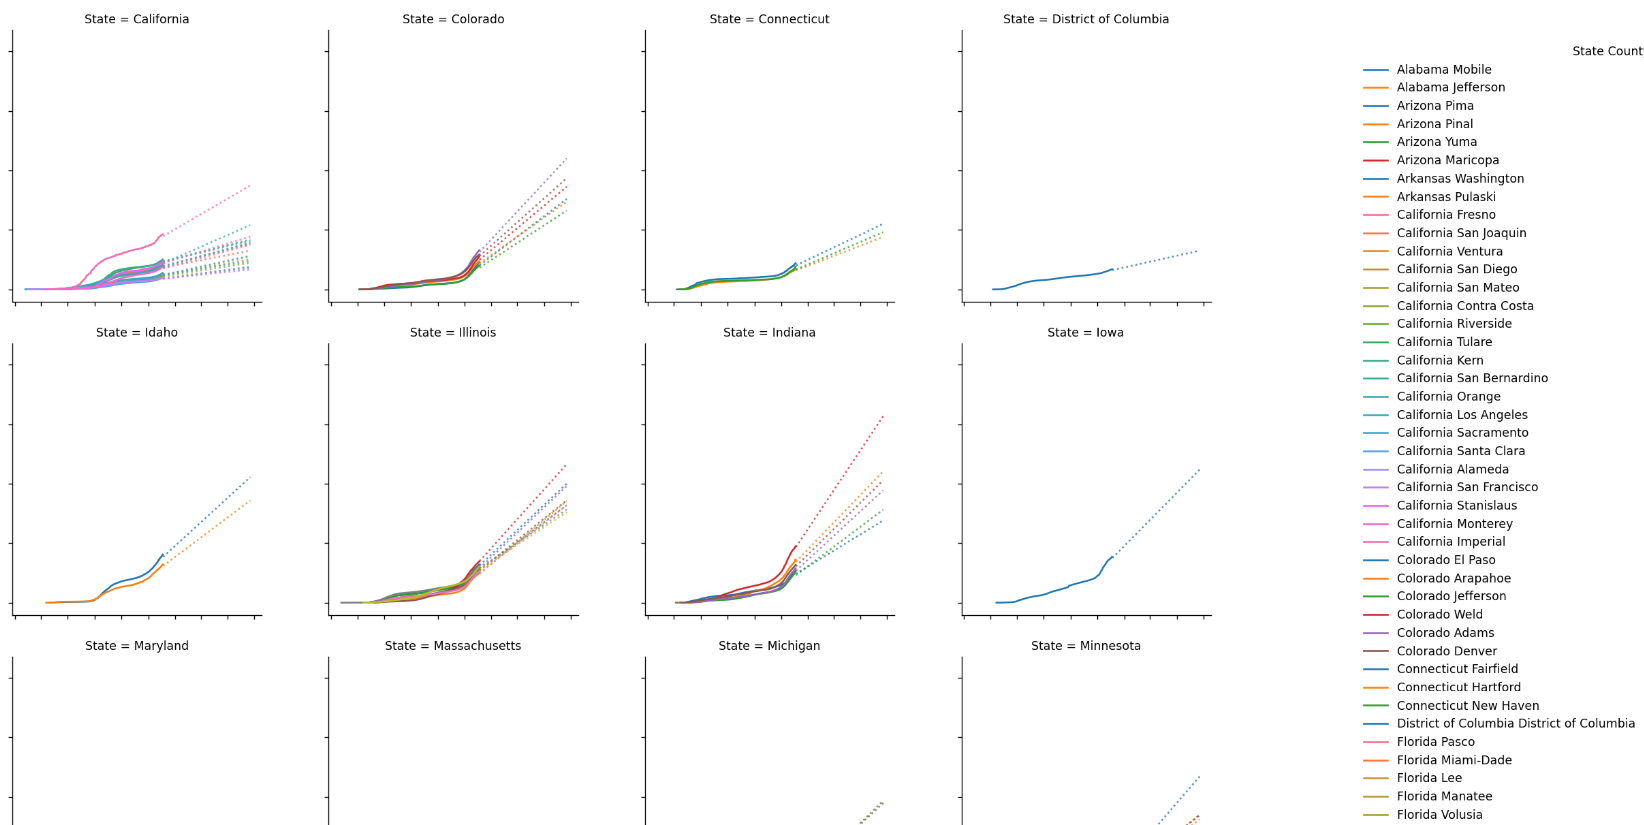

# Code

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import plotly.express as px
import matplotlib.dates as mdates
%matplotlib inline
from pylab import rcParams
pd.options.display.max_rows=100#Notebook 的一个cell的显示行数
pd.options.display.max_columns=100#Notebook 的一个cell的显示列数
pd.options.display.float_format = '{:,.2f}'.format
std = StandardScaler()
mms = MinMaxScaler()

In [ ]:
filename = '../input/us-counties-covid19-weather-sociohealth-data/US_counties_COVID19_health_weather_data.csv'

#select significant factor based on regression analysis showed below
df1 = pd.read_csv(filename)
df2 = df1[['date',
 'county',
 'state',
 'fips',
 'cases',
 'deaths',
 'percent_less_than_18_years_of_age',
 'percent_65_and_over',
 'percent_below_poverty',
 'mean_temp',
 'total_population',
 'population_density_per_sqmi',
 'violent_crime_rate',
 'percent_black',
 'percent_asian',
 'percent_hispanic',
 'percent_non_hispanic_white',
 'percent_female',
 'percent_rural',
 'percent_overcrowding']
]
df2.columns=['Date',
 'County',
 'State',
 'fips',
 'cases',
 'deaths',
 '<18',
 '>65',
 '<poverty',
 'temp',
 'population',
 'population_density_per_sqmi',
 'violent_crime_rate',
 'percent_black',
 'percent_asian',
 'percent_hispanic',
 'percent_non_hispanic_white',
 'percent_female',
 'percent_rural',
 'percent_overcrowding']

In [ ]:
#Calculate infection rate, death rate
df2.loc[:,'casep'] = df2['cases']/df2['population']*100
df2.loc[:,'deathp'] = df2['deaths']/df2['cases']*100

#Create dataframe for futhre calculation
df2['Date']=pd.to_datetime(df2['Date'])
df2.head()
dfc = df2.groupby(['County','State']).agg('max').reset_index()
dfc = dfc.sort_values('cases', ascending=0)
#get the top 200 counties with highest cases
dfc['ct'] = dfc['State'] + ' '+ dfc['County'] 
df2['ct'] =  df2['State'] + ' '+ df2['County']
namelist = dfc['ct'].unique()[:200].tolist()

#data for top25 county cases evolving
dfwc = df2[df2['ct'].isin(namelist)].sort_values('cases',ascending=1).reset_index().drop(['index','fips'],axis=1)

In [ ]:
#overall dataframe for training based on fbprophet model
df_pre = df2.groupby(['Date']).agg('sum').reset_index()
df_pre = df_pre[['Date','cases']]
df_pre.columns=['ds','y']

In [ ]:
#fbprophet parameter tunning, the parameter was tunned several times and the value showed below is based on final result
import itertools
from fbprophet.diagnostics import cross_validation,performance_metrics
cutoffs = pd.to_datetime(['2020-03-01', '2020-06-01', '2020-09-01'])
param_grid = {  
    'changepoint_prior_scale': [8,80],'seasonality_prior_scale': [0.1,1,10],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df_pre)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)
best_params = all_params[np.argmin(rmses)]
print(best_params)

In [ ]:
#Besides cross validation, we compare the real data in 2021 with prediction as well.
#The result predicted about 22 million cases in mid of Feb.2021, comparing the real number 26 million in Feb.2021, is basically acceptable. 
#The prediction error is due to a sharp increase in Jan2021 which was not reflected in 2020 data.
m = Prophet(changepoint_prior_scale= 80)
m.fit(df_pre)
future = m.make_future_dataframe(periods=80)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)

In [ ]:
px.area(forecast, x='ds', y='yhat')

In [ ]:
#train and predict based on history data of each top200 infected county
tem = pd.DataFrame(columns=['Date','County','casep'])
for i in namelist:
    m = Prophet(changepoint_prior_scale= 80)
    df_train = dfwc[dfwc.ct==i][['Date','casep']].rename(columns={'Date':'ds','casep':'y'})
    m.fit(df_train)
    future = m.make_future_dataframe(periods=200)
    forecast = m.predict(future)
    forecast['County'] = dfwc[dfwc.ct==i].ct.unique()[0]
    forecast['State'] = dfwc[dfwc.ct==i].State.unique()[0]
    tempdf = forecast[['ds','County','yhat','State']].iloc[-200:,:]
    tempdf.columns=['Date','County','casep','State']
    tem = tem.append(tempdf,ignore_index=True)
tem = tem.rename({'casep':'Casep'},axis=1)

In [ ]:
#append dfwc and temp to final dataframe for plot
findf = dfwc[['Date','ct','casep','State']].rename({'ct':'County'},axis=1)
findf = findf.append(tem,ignore_index=True)
#Drop two states that only have 1 county in top 200 infected county
ind = findf[findf.State.isin(['Alaska','Delaware'])].index
findf = findf.drop(ind)

In [ ]:
#draw the Top200 county performance by seaborn facetgrid
a = findf.State.unique().tolist()
a = sorted(a)
g = sns.FacetGrid(findf, col='State', col_wrap=7,col_order=a)
g.map_dataframe(sns.lineplot, x='Date', y='casep',hue='County')
g.map_dataframe(sns.lineplot, x='Date', y='Casep',hue='County',alpha=0.8,linestyle=":")
g.set_ylabels('%Infection Rate')
g.set(xticklabels=['01/2020','','','','12/2020','','','','06/2021','',''])
#g.format_xdata = mdates.DateFormatter('%mm/%YY')
g.set_xticklabels(size = 9)
g.add_legend(ncol=2,loc = 'right')
g._legend.set_title("State County")
#output the fiture
g.savefig("output.png")